# Shipments of medicines between 2007-2015 to Africa

LINK TO KAGGLE DATASET: https://www.kaggle.com/divyeshardeshana/supply-chain-shipment-pricing-data

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import geopy.distance
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 500


%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv(".\\data\\SCMS_Delivery_History_Dataset.csv")

# NaN inputting
df["PQ First Sent to Client Date"] = df["PQ First Sent to Client Date"]\
                                     .apply(lambda s: np.nan if s == "Date Not Captured"
                                            else s)
df["PO Sent to Vendor Date"] = df["PQ First Sent to Client Date"]\
                                     .apply(lambda s: np.nan if s in ["Date Not Captured",
                                                                      "N/A - From RDC"]
                                            else s)
df["Weight (Kilograms)"] = df["Weight (Kilograms)"]\
                                     .apply(lambda s: np.nan if s == "Weight Captured Separately"
                                            else s)
# Fix weight
df["Weight (Kilograms)"] = df["Weight (Kilograms)"].apply(lambda v: v if not isinstance(v, str)
                                                          or v.isnumeric()
                                                          else
                                                          df.loc[(df["ASN/DN #"] == v.split(" ")[1]) &
                                                                 (df["ID"] == int(v.split(":")[-1].strip("()"))),
                                                                 "Weight (Kilograms)"].values[0])
df["Weight (Kilograms)"] = df["Weight (Kilograms)"].astype(float)

# Fix Freight Cost
df["Freight Cost (USD)"] = df["Freight Cost (USD)"].apply(lambda s: 0
                                                          if s == "Freight Included in Commodity Cost"
                                                          else np.nan if s == "Invoiced Separately" else s)
df["Freight Cost (USD)"] = df["Freight Cost (USD)"].apply(lambda v: df.loc[(df["ASN/DN #"] == v.split(" ")[1]) &
                                                                           (df["ID"] == int(v.split(":")[-1].strip("()"))),
                                                                           "Freight Cost (USD)"].values[0]
                                                          if isinstance(v, str) and "See" in v
                                                          else v).astype(float)

# Fix Subclassification
df["Sub Classification"] = df["Sub Classification"].apply(lambda s: s.split(" - ")[0]
                                                          if "Ancillary" in s else s)

Shipment Mode : 360  |  3.49 %
PQ First Sent to Client Date : 205  |  1.99 %
PO Sent to Vendor Date : 205  |  1.99 %
Dosage : 1736  |  16.82 %
Weight (Kilograms) : 1633  |  15.82 %
Freight Cost (USD) : 344  |  3.33 %
Line Item Insurance (USD) : 287  |  2.78 %


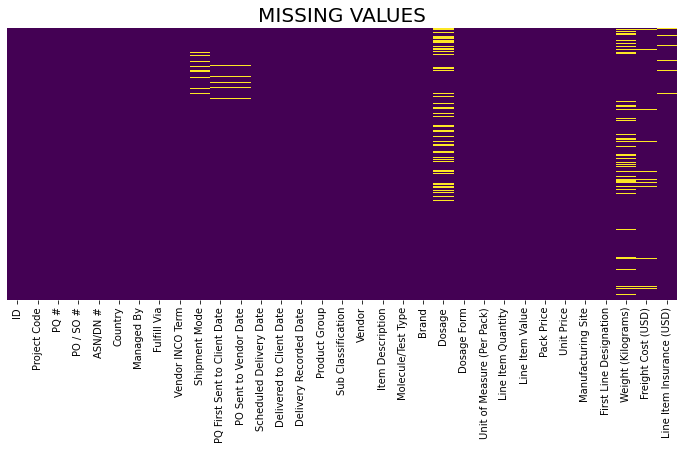

In [3]:
plt.figure(figsize = (12, 5))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = "viridis")
plt.title("MISSING VALUES", fontsize =20)

for x in df.columns:
    if df[x].isna().sum() > 0:
        print(x, ": {miss}  |  {per} %".format(miss = df[x].isna().sum(),
                                               per = round(df[x].isna().sum()/len(df)*100, 2) ))             

In [9]:
# Input median weight based on product
df[df["Weight (Kilograms)"].isnull()][["ASN/DN #", "Weight (Kilograms)"]]

,ASN/DN #,Weight (Kilograms)
12,ASN-144,NaN
15,ASN-285,NaN
16,ASN-608,NaN
31,ASN-1251,NaN
35,ASN-1269,NaN
...,...,...
10189,DN-3324,NaN
10190,DN-3325,NaN
10300,DN-4215,NaN
10321,DN-4316,NaN


In [ ]:
df.loc[dfdf["Weight (Kilograms)"].isnull(), "Weight (Kilograms)"] = ???

In [7]:
df.pivot_table(index = "ASN/DN #", values = "Weight (Kilograms)",
               aggfunc = np.nanmedian).reset_index()

,ASN/DN #,Weight (Kilograms)
0,ASN-10006,94.0
1,ASN-10007,43.0
2,ASN-10062,453.0
3,ASN-10063,8.0
4,ASN-10064,205.0
...,...,...
6367,DN-995,26.0
6368,DN-996,501.0
6369,DN-997,3720.0
6370,DN-998,585.0


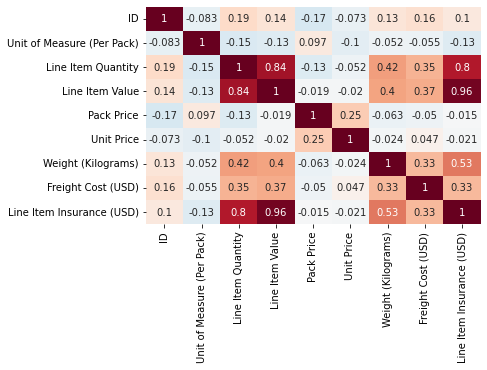

In [4]:
sns.heatmap(df.corr(), cmap = "RdBu_r", annot = True, vmin = -1, vmax = 1, cbar = False)
plt.show()

## Cleaning and Feature engineering

In [ ]:
# Dates columns
for dcol in ["Scheduled Delivery Date", "Delivered to Client Date",
             "Delivery Recorded Date"]:
    df[dcol] = pd.to_datetime(df[dcol])

df["Scheduled Delivery YEAR"] = df["Scheduled Delivery Date"].dt.year
df["Scheduled Delivery MONTH"] = df["Scheduled Delivery Date"].dt.month
df["Scheduled Delivery DAY"] = df["Scheduled Delivery Date"].dt.day

# Delays
df["Delay for Customer"] = (df["Delivered to Client Date"] -\
                            df["Scheduled Delivery Date"]).dt.days.astype("int64")
df["Delay in Recording"] = (df["Delivery Recorded Date"] -\
                            df["Delivered to Client Date"]).dt.days.astype("int64")

# Drop date columns
df = df.drop(["Scheduled Delivery Date", "Delivered to Client Date",
              "Delivery Recorded Date"], axis = 1)

# Drop rows where Shipment Mode is not available
df = df[df["Shipment Mode"].notna()].reset_index(drop = True)

In [ ]:
### Dummy Encoding
# Shipment Mode
df = pd.concat([df.drop("Shipment Mode", axis = 1),
                pd.get_dummies(df["Shipment Mode"], drop_first = True)], axis = 1)
# Fulfill Via
df = pd.concat([df.drop("Fulfill Via", axis = 1),
                pd.get_dummies(df["Fulfill Via"], drop_first = True)], axis = 1)

# Managed by
df["Managed By"] = df["Managed By"].apply(lambda s: 1 if s == "PMO - US" else 0)
df = df.rename(columns = {"Managed By": "PMO - US Managed"})

# First Line Designation
df["First Line Designation"] = df["First Line Designation"].map({"Yes": 1, "No": 0})

# Dosage Form
# NOTE: grouping is done without any prior domain knowledge
df["Dosage Form"] = df["Dosage Form"].apply(lambda s: "Tablet" if "tablet" in s.lower()
                                            else "Powder" if "powder" in s.lower()
                                            else "Capsule" if "capsule" in s.lower()
                                            else "Test kit" if "test kit" in s.lower()
                                            else s)
df = pd.concat([df.drop("Dosage Form", axis = 1),
                pd.get_dummies(df["Dosage Form"], drop_first = True)], axis = 1)

# Sub Classification
df = pd.concat([df.drop("Sub Classification", axis = 1),
                pd.get_dummies(df["Sub Classification"], drop_first = True)], axis = 1)

In [ ]:
### Geographic data

# Manufacturing Site
man_site = pd.read_table("man_site.txt", sep = "|")
dms = dict(zip(man_site["Site"],
               man_site[["Latitude", "Longitude"]].values.tolist()))

df["Manufacturing Site Coords"] = df["Manufacturing Site"].map(dms)

# Country
coun_coord = pd.read_table("country_loc.txt", sep = "|")
dcc = dict(zip(coun_coord["Country"],
               coun_coord[["Latitude", "Longitude"]].values.tolist()))

df["Country Coords"] = df["Country"].map(dcc)

# New col: Distance
df["Distance Manuf Dest"] = [ geopy.distance.distance(df["Country Coords"][x],
                                                      df["Manufacturing Site Coords"][x]).km
                             for x in range(len(df)) ]
df = df.drop(["Manufacturing Site", "Country",
              "Manufacturing Site Coords", "Country Coords"], axis = 1)

In [ ]:
# Drop some columns (mainly textual attributes of the transaction/prodcut)
# 'Line Item Insurance (USD)'' is removed as it is highly
# correlated with 'Line Item Value' (r = .96)
# 'Product Group' is highly correlated (via contingency table)
# with 'Sub Classification'
df = df.drop(["ID", "Item Description", "PQ #", "ASN/DN #", "PO / SO #", "Dosage",
              "Line Item Insurance (USD)", "Molecule/Test Type", "Project Code",
              "PQ First Sent to Client Date", "PO Sent to Vendor Date",
              "Product Group",
              # Text columns
              "Vendor INCO Term", "Vendor", "Brand"], axis = 1)

In [ ]:
# NEW ANALYSIS OF CORRELATIONS
plt.figure(figsize = (18, 8))
sns.heatmap(df.corr(), annot = True, cbar = False,
            vmin = -1, vmax = 1, cmap = "RdBu_r")
plt.show()